In [147]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from datetime import date
import investpy

In [181]:
start_date = "2015-01-01"
end_date = "2023-01-01"

# Define the stock symbols
target_stock = "BMRI.JK"
feature_stocks = pd.read_excel('../data/raw/Daftar Index.xlsx')['Symbol'].to_list()
#feature_stocks = ['^JKII', '^JKLQ45', '^JKSE']

# Download stock data
target_data = yf.download(target_stock, start=start_date, end=end_date, interval='1d')["Adj Close"]
feature_data = yf.download(feature_stocks, start=start_date, end=end_date, interval='1d')["Adj Close"]

target_data
# Use adjusted closing prices for the target stock
target_data = target_data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  42 of 42 completed

38 Failed downloads:
- INVESTOR33.JK: Period 'max' is invalid, must be one of ['1d', '5d']
- IDXSHAGROW.JK: Period 'max' is invalid, must be one of ['1d', '5d']
- IDXSMC-COM.JK: Period 'max' is invalid, must be one of ['1d', '5d']
- ISSI.JK: Period 'max' is invalid, must be one of ['1d', '5d']
- IDXHIDIV20.JK: Period 'max' is invalid, must be one of ['1d', '5d']
- IDXTECHNO.JK: Period 'max' is invalid, must be one of ['1d', '5d']
- IDXPROPERT.JK: Period 'max' is invalid, must be one of ['1d', '5d']
- IDXENERGY.JK: Period 'max' is invalid, must be one of ['1d', '5d']
- IDXNONCYC.JK: Period 'max' is invalid, must be one of ['1d', '5d']
- IDXCYCLIC.JK: Period 'max' is invalid, must be one of ['1d', '5d']
- IDX80.JK: Period 'max' is invalid, must be one of ['1d', '5d']
- SMINFRA18.JK: Period 'max' is invalid, must be one of ['1d', '5d']
- KOMPAS100.JK

In [163]:

feature_data


,^JKII,^JKLQ45,^JKSE
Date,,,
2015-01-02,694.469971,903.130005,5242.769043
2015-01-05,689.090027,898.270020,5219.995117
2015-01-06,681.070007,888.200012,5169.060059
2015-01-07,687.510010,897.510010,5207.118164
2015-01-08,688.140015,898.000000,5211.828125
...,...,...,...
2022-12-26,591.210022,935.150024,6835.808105
2022-12-27,592.369995,940.380005,6923.026855
2022-12-28,587.169983,933.690002,6850.520020


In [164]:
# Merge target and feature data
data = pd.concat([target_data, feature_data], axis=1)
data.columns = [target_stock] + feature_stocks

# Fill any missing values with the previous day's value
#data.fillna(method="ffill", inplace=True)
data.dropna(inplace=True)
data



,BMRI.JK,^JKII,^JKLQ45,^JKSE
Date,,,,
2015-01-02,1898.832764,694.469971,903.130005,5242.769043
2015-01-05,1894.447876,689.090027,898.270020,5219.995117
2015-01-06,1881.291748,681.070007,888.200012,5169.060059
2015-01-07,1903.218262,687.510010,897.510010,5207.118164
2015-01-08,1920.759277,688.140015,898.000000,5211.828125
...,...,...,...,...
2022-12-26,4780.970703,591.210022,935.150024,6835.808105
2022-12-27,4733.398926,592.369995,940.380005,6923.026855
2022-12-28,4745.291992,587.169983,933.690002,6850.520020


In [174]:
train_ratio = 0.8
train_size = int(len(data) * train_ratio)
train_data = data[:train_size]
test_data = data[train_size:]

from sklearn.model_selection import train_test_split

X = data.iloc[:,0]
y = data.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)




In [175]:
model = auto_arima(
    X_train,
    exogenous=y_train,
    seasonal=True,
    m=5,
    trace=True,
    stepwise=True,
    suppress_warnings=True,
)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[5] intercept   : AIC=24973.013, Time=2.05 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=24968.407, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=24970.365, Time=0.38 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=24969.931, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=29145.669, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[5] intercept   : AIC=24970.330, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[5] intercept   : AIC=24969.206, Time=0.31 sec
 ARIMA(0,0,0)(1,0,1)[5] intercept   : AIC=24971.206, Time=0.47 sec
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=24968.897, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : AIC=24969.008, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[5] intercept   : AIC=24970.911, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[5] intercept
Total fit time: 3.818 seconds


In [176]:
sarimax_model = SARIMAX(
    X_train,
    exog=y_train,
    order=model.order,
    seasonal_order=model.seasonal_order,
).fit(disp=False)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has bee

In [177]:
predictions = sarimax_model.predict(
    start=len(X_train),
    end=len(X_train) + len(X_test) - 1,
    exog=y_test
)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [178]:
mse = mean_squared_error(X_test, predictions)
rmse = np.sqrt(mse)
print("RMSE:", rmse)


RMSE: 312.012162111453


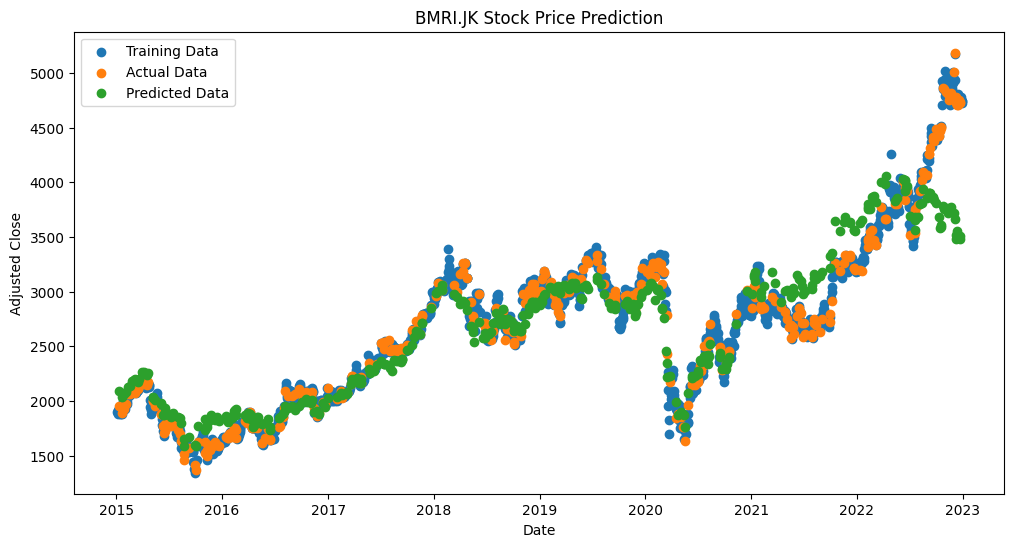

In [180]:
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.scatter(X_train.index, X_train, label="Training Data")
plt.scatter(X_test.index, X_test, label="Actual Data")
plt.scatter(X_test.index, predictions, label="Predicted Data")
plt.xlabel("Date")
plt.ylabel("Adjusted Close")
plt.title(f"{target_stock} Stock Price Prediction")
plt.legend()
plt.show()



In [159]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic: {:.2f}".format(result[0]))
    print("p-value: {:.2e}".format(result[1]))
    print("Critical Values:")
    for key, value in result[4].items():
        print("\t{}: {:.2f}".format(key, value))

def plot_correlogram(series, title):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(series, ax=axes[0], lags=50)
    plot_pacf(series, ax=axes[1], lags=50)
    fig.suptitle(title)
    plt.show()


In [160]:
print("Augmented Dickey-Fuller Test on", target_stock)
adf_test(target_data.dropna())


Augmented Dickey-Fuller Test on BMRI.JK
ADF Statistic: -0.41
p-value: 9.09e-01
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


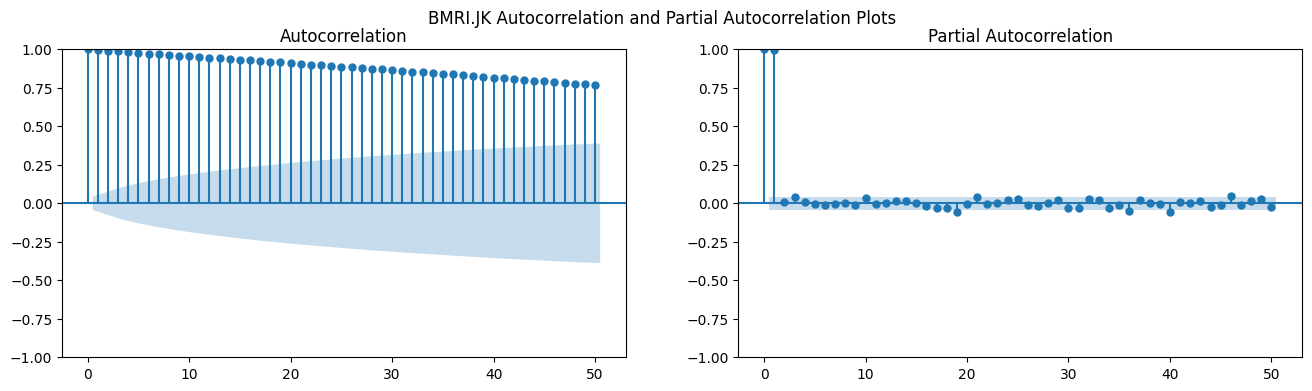

In [161]:
plot_correlogram(target_data.dropna(), f"{target_stock} Autocorrelation and Partial Autocorrelation Plots")


[*********************100%***********************]  4 of 4 completed
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.87819D+00    |proj g|=  7.77241D+00

At iterate    5    f= -2.88156D+00    |proj g|=  5.10104D-01

At iterate   10    f= -2.88547D+00    |proj g|=  8.84391D+00


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f= -2.90109D+00    |proj g|=  6.04690D-02

At iterate   20    f= -2.90115D+00    |proj g|=  5.18065D-01

At iterate   25    f= -2.90475D+00    |proj g|=  2.99823D+00

At iterate   30    f= -2.90686D+00    |proj g|=  7.94052D-02

At iterate   35    f= -2.92751D+00    |proj g|=  3.22983D+00

At iterate   40    f= -2.95615D+00    |proj g|=  1.75654D+00

At iterate   45    f= -2.95859D+00    |proj g|=  3.90123D-02

At iterate   50    f= -2.95860D+00    |proj g|=  1.30933D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   1.309D-01  -2.959D+00
  F =  -2.95860083631

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/fy/zhbysd194v9gxlrksl8f4bp80000gn/T/ipykernel_61278/2848972862.py:46: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_loc = data_log_returns.index.get_loc(test_data.index[0], method='nearest')
/var/folders/fy/zhbysd194v9gxlrksl8f4bp80000gn/T/ipykernel_61278/2848972862.py:47: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end_loc = data_log_returns.index.get_loc(test_data.index[-1], method='nearest')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa

Mean Squared Error (Log Returns): 0.00019435941444091265


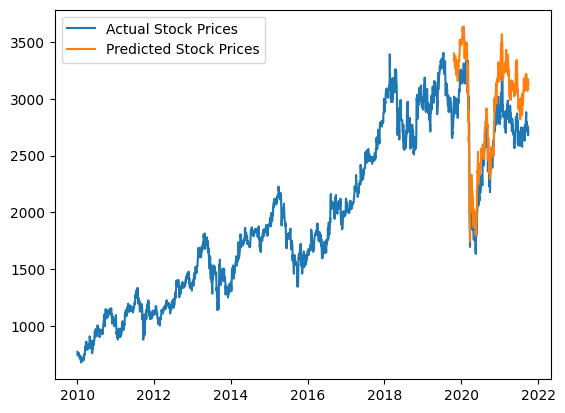

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Function to download stock data
def download_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Function to calculate log returns
def calculate_log_returns(data):
    log_returns = np.log(data) - np.log(data.shift(1))
    log_returns.dropna(inplace=True)
    return log_returns

# Fetch data using yfinance
tickers = ['^JKII', '^JKLQ45', '^JKSE', 'BMRI.JK']
start_date = '2010-01-01'
end_date = '2021-09-30'

data = download_stock_data(tickers, start_date, end_date)

# Calculate log returns for both target and feature columns
data_log_returns = calculate_log_returns(data)

# Split data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(data_log_returns))[-1]
train_data = data_log_returns.iloc[train_index]
test_data = data_log_returns.iloc[test_index]

# Train SARIMAX model
target_stock = 'BMRI.JK'
feature_stock = ['^JKII', '^JKLQ45', '^JKSE']
exog_train = train_data[feature_stock]

model = SARIMAX(train_data[target_stock], exog=exog_train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
results = model.fit()

# Make predictions
# Make predictions
start_loc = data_log_returns.index.get_loc(test_data.index[0], method='nearest')
end_loc = data_log_returns.index.get_loc(test_data.index[-1], method='nearest')
pred_log_returns = results.get_prediction(start=start_loc, end=end_loc, exog=exog_test).predicted_mean

# Convert predictions back to stock prices
initial_stock_price = data[target_stock].iloc[train_index[-1]]
predicted_stock_prices = [initial_stock_price * np.exp(cum_log_ret) for cum_log_ret in np.cumsum(pred_log_returns)]
predicted_stock_prices = pd.Series(predicted_stock_prices, index=test_data.index)

# Evaluate the model
# Evaluate the model on log return data
mse_log_returns = mean_squared_error(test_data[target_stock], pred_log_returns)
print(f"Mean Squared Error (Log Returns): {mse_log_returns}")


# Visualize the results
plt.plot(data[target_stock], label='Actual Stock Prices')
plt.plot(predicted_stock_prices, label='Predicted Stock Prices')
plt.legend()
plt.show()


In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Function to download stock data
def download_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Function to calculate log returns
def calculate_log_returns(data):
    log_returns = np.log(data) - np.log(data.shift(1))
    log_returns.dropna(inplace=True)
    return log_returns

# Function to split the data into train, validation, and test sets
def split_data(data, train_ratio, validation_ratio, test_ratio):
    train_size = int(len(data) * train_ratio)
    validation_size = int(len(data) * validation_ratio)
    
    train_data = data[:train_size]
    validation_data = data[train_size:train_size + validation_size]
    test_data = data[train_size + validation_size:]
    
    return train_data, validation_data, test_data

# Fetch data using yfinance
tickers = ['^JKII', '^JKLQ45', '^JKSE', 'BMRI.JK']
start_date = '2010-01-01'
end_date = '2021-09-30'

data = download_stock_data(tickers, start_date, end_date)

# Calculate log returns for both target and feature columns
data_log_returns = calculate_log_returns(data)

# Split data into train, validation, and test sets
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

train_data, validation_data, test_data = split_data(data_log_returns, train_ratio, validation_ratio, test_ratio)

# Train SARIMAX model
target_stock = 'BMRI.JK'
feature_stock = ['^JKII', '^JKLQ45', '^JKSE']
exog_train = train_data[feature_stock]

model = SARIMAX(train_data[target_stock], exog=exog_train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
results = model.fit()

# Validate the model using validation_data
start_loc_validation = data_log_returns.index.get_loc(validation_data.index[0], method='nearest')
end_loc_validation = data_log_returns.index.get_loc(validation_data.index[-1], method='nearest')
exog_validation = data_log_returns.iloc[start_loc_validation:end_loc_validation+1][feature_stock]
pred_log_returns_validation = results.get_prediction(start=start_loc_validation, end=end_loc_validation, exog=exog_validation).predicted_mean

# Evaluate the model on log return validation data
mse_log_returns_validation = mean_squared_error(validation_data[target_stock], pred_log_returns_validation)
print(f"Mean Squared Error (Log Returns Validation): {mse_log_returns_validation}")

# Make predictions using test_data
start_loc_test = data_log_returns.index.get_loc(test_data.index[0], method='nearest')
end_loc_test = data_log_returns.index.get_loc(test_data.index[-1], method='nearest')
exog_test = data_log_returns.iloc[start_loc_test:end_loc_test+1][feature_stock]
print(f"start_loc_test: {start_loc_test}, end_loc_test: {end_loc_test}")
print(f"exog_test.shape: {exog_test.shape}, expected shape: {(end_loc_test - start_loc_test + 1, len(feature_stock))}")

pred_log_returns_test = results.get_prediction(start=start_loc_test, end=end_loc_test, exog=exog_test).predicted_mean

# Evaluate the model on log return test data
mse_log_returns_test = mean_squared_error(test_data[target_stock], pred_log_returns_test)
print(f"Mean Squared Error (Log Returns Test): {mse_log_returns_test}")

# Convert predictions back to stock prices
initial_stock_price = data[target_stock].iloc[train_data.index[-1]]
predicted_stock_prices = [initial_stock_price * np.exp(cum_log_ret) for cum_log_ret in np.cumsum(pred_log_returns_test)]
predicted_stock_prices = pd.Series(predicted_stock_prices, index=test_data.index)

# Visualize the results
plt.plot(data[target_stock], label='Actual Stock Prices')
plt.plot(predicted_stock_prices, label='Predicted Stock Prices')
plt.legend()
plt.show()


[*********************100%***********************]  4 of 4 completed
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90066D+00    |proj g|=  7.97965D+00

At iterate    5    f= -2.90406D+00    |proj g|=  4.93701D-01

At iterate   10    f= -2.90761D+00    |proj g|=  8.63462D+00

At iterate   15    f= -2.92288D+00    |proj g|=  7.25871D-02


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f= -2.92294D+00    |proj g|=  5.08631D-01

At iterate   25    f= -2.92668D+00    |proj g|=  3.10532D+00

At iterate   30    f= -2.93242D+00    |proj g|=  1.75134D+00

At iterate   35    f= -2.97483D+00    |proj g|=  2.18758D+00

At iterate   40    f= -2.98233D+00    |proj g|=  1.92363D-01

At iterate   45    f= -2.98322D+00    |proj g|=  3.92021D-01

At iterate   50    f= -2.98585D+00    |proj g|=  1.68280D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   1.683D-02  -2.986D+00
  F =  -2.9858481973678739     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/fy/zhbysd194v9gxlrksl8f4bp80000gn/T/ipykernel_61278/2493921072.py:56: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_loc_validation = data_log_returns.index.get_loc(validation_data.index[0], method='nearest')
/var/folders/fy/zhbysd194v9gxlrksl8f4bp80000gn/T/ipykernel_61278/2493921072.py:57: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end_loc_validation = data_log_returns.index.get_loc(validation_data.index[-1], method='nearest')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python

ValueError: Provided exogenous values are not of the appropriate shape. Required (848, 3), got (425, 3).

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# Create a sample dataset
data = np.arange(1, 101).reshape(-1, 1)
df = pd.DataFrame(data, columns=['Value'])

# Define the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the train, validation, and test sets
train_set = None
validation_set = None
test_set = None

# Perform time series splitting
for train_index, test_index in tscv.split(df):
    train_set, test_set = df.iloc[train_index], df.iloc[test_index]

    # Calculate the index for validation set
    validation_index = int(len(train_index) * 0.7)

    # Separate the train and validation sets
    train_set, validation_set = train_set.iloc[:validation_index], train_set.iloc[validation_index:]

    print("Train Set:")
    print(train_set)
    print("\nValidation Set:")
    print(validation_set)
    print("\nTest Set:")
    print(test_set)
    print("\n--------------------------------------\n")


Train Set:
    Value
0       1
1       2
2       3
3       4
4       5
5       6
6       7
7       8
8       9
9      10
10     11
11     12
12     13
13     14

Validation Set:
    Value
14     15
15     16
16     17
17     18
18     19
19     20

Test Set:
    Value
20     21
21     22
22     23
23     24
24     25
25     26
26     27
27     28
28     29
29     30
30     31
31     32
32     33
33     34
34     35
35     36

--------------------------------------

Train Set:
    Value
0       1
1       2
2       3
3       4
4       5
5       6
6       7
7       8
8       9
9      10
10     11
11     12
12     13
13     14
14     15
15     16
16     17
17     18
18     19
19     20
20     21
21     22
22     23
23     24
24     25

Validation Set:
    Value
25     26
26     27
27     28
28     29
29     30
30     31
31     32
32     33
33     34
34     35
35     36

Test Set:
    Value
36     37
37     38
38     39
39     40
40     41
41     42
42     43
43     44
44     45
45     46
4